In [0]:
from keras.applications import VGG16

Using TensorFlow backend.


In [0]:
model = VGG16(weights='imagenet')

W0803 09:56:27.013281 139943299635072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0803 09:56:27.060163 139943299635072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0803 09:56:27.068589 139943299635072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0803 09:56:27.104795 139943299635072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



553467904/553467096 [==============================] - 6s 0us/step


W0803 09:56:33.617483 139943299635072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0803 09:56:33.618551 139943299635072 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [1]:
# from google.colab import files
# files.upload()

In [0]:
!ls

cat.jpg  sample_data


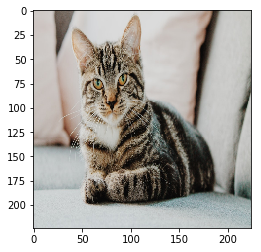

In [0]:
import matplotlib.pyplot as plt

import cv2
img = cv2.imread('cat.jpg')
img = cv2.resize(img,(224,224))
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [0]:
img = img.reshape((1,*img.shape))

In [0]:
print(img.shape)

(1, 224, 224, 3)


In [0]:
pred = model.predict(img)

In [0]:
from keras.applications.vgg16 import decode_predictions
decode_predictions(pred,top=3)[0]

40960/35363 [==================================] - 0s 0us/step


[('n02123045', 'tabby', 0.3571398),
 ('n02123159', 'tiger_cat', 0.34323272),
 ('n02124075', 'Egyptian_cat', 0.25828928)]

In [0]:
model = VGG16(input_shape=(224,224,3),include_top=False,weights='imagenet')

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [0]:
layers = ['block1_conv1','block3_conv2'] #64,512

outputs = []
for l in model.layers:
    if l.name in layers:
        outputs.append(l.output)

In [0]:
outputs

[<tf.Tensor 'block1_conv1_1/Relu:0' shape=(?, 224, 224, 64) dtype=float32>,
 <tf.Tensor 'block3_conv2_1/Relu:0' shape=(?, 56, 56, 256) dtype=float32>]

In [0]:
# Functional API
from keras.models import Model
activation_model  = Model(inputs=model.input,outputs=outputs)


In [0]:
l1,l2 = activation_model.predict(img)

In [0]:
img_l1 = l1[0]
print(img_l1.shape)

(224, 224, 64)


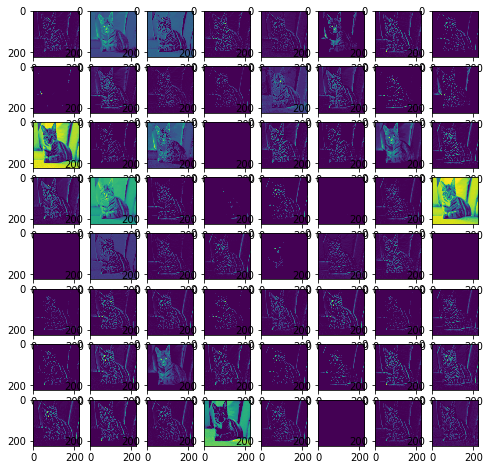

In [0]:
plt.figure(figsize=(8,8))
for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(img_l1[...,i],cmap='viridis')
    
plt.show()

In [0]:
img_l2 = l2[0]
print(img_l2.shape)

(56, 56, 256)


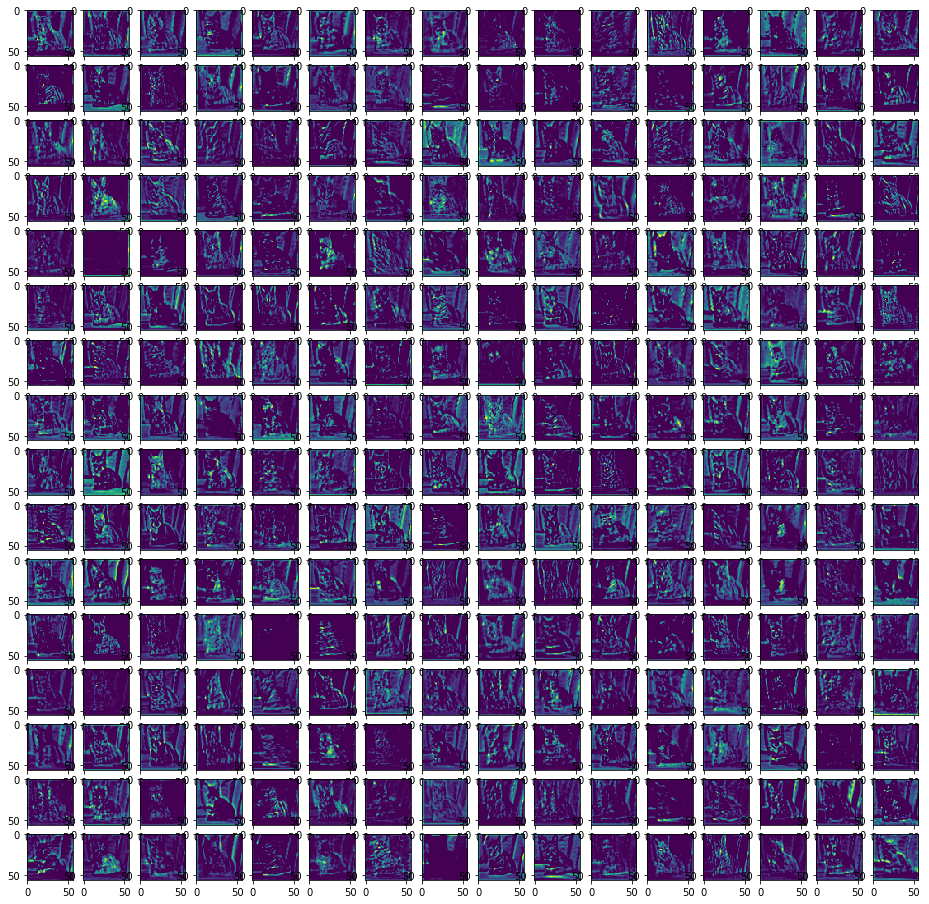

In [0]:
plt.figure(figsize=(16,16))
for i in range(256):
    plt.subplot(16,16,i+1)
    plt.imshow(img_l2[...,i],cmap='viridis')
    
plt.show()

In [0]:
from keras import backend as K

# Filter Visualisation
layer_name = 'block3_conv2'

# Loss
idx = 0


In [0]:
import numpy as np
def get_pattern(layer_name,idx,steps=50):
    layer_output = model.get_layer(layer_name).output
    
    # Gradient
    
    loss = K.mean(layer_output[:,:,:,idx])
    grads = K.gradients(loss,model.input)[0]
    
    
    # Gradient Normalisation
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Start with a Random Image
    input_img = np.random.random((1,200,200,3))*20 + 128
    
    # Iterate Function
    iterate = K.function([model.input],[loss,grads])
    
    # Run Gradient Ascent
    lr = 1
    
    for i in range(steps):
        loss_value,grad_val = iterate([input_img])
        input_img += grad_val*lr
    
    
    # Normalize the Output
    x = input_img
    x -= x.mean()
    x /= (x.std()+1e-5)
    
    #Clip to [0,1]
    x *= 0.1
    x += 0.5
    x = np.clip(x,0,1)

    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    
    
    return x[0]

    

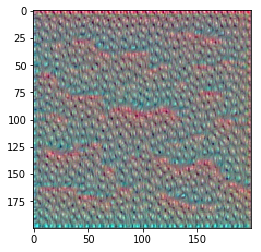

In [0]:
patt1  = get_pattern(layer_name,idx=165)
plt.imshow(patt1)
plt.show()

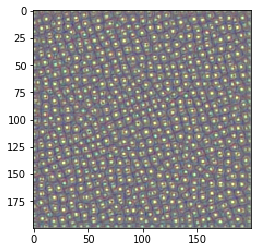

In [0]:
patt1  = get_pattern('block3_conv2',8)
plt.imshow(patt1)
plt.show()

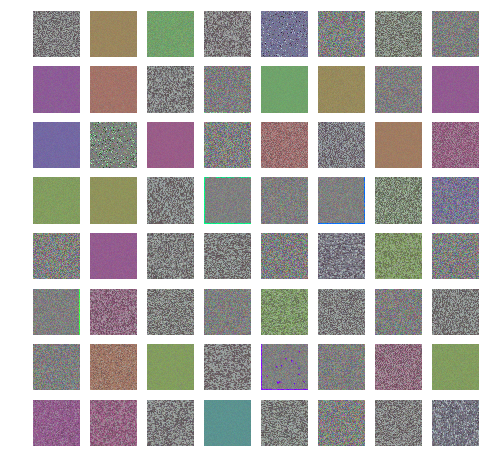

In [0]:
plt.figure(figsize=(8,8))

for i in range(64):
    plt.subplot(8,8,i+1)
    patt1  = get_pattern('block1_conv1',i)
    plt.imshow(patt1)
    plt.axis("off")
plt.show()

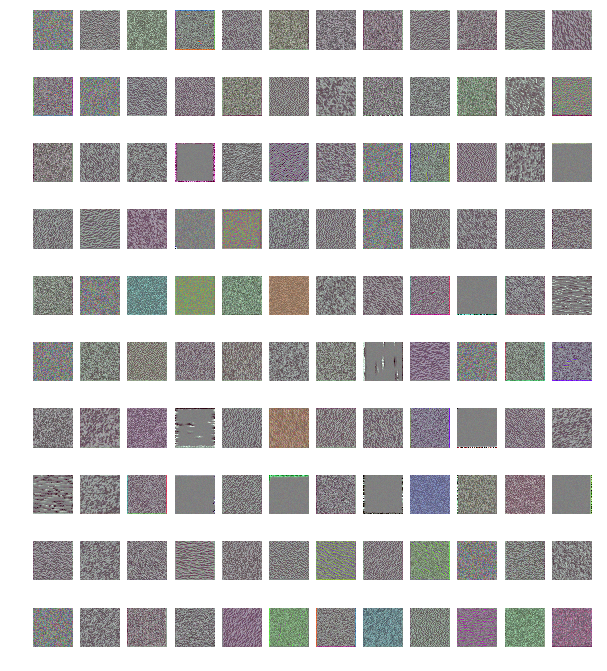

In [0]:
plt.figure(figsize=(10,12))

for i in range(120):
    plt.subplot(10,12,i+1)
    patt1  = get_pattern('block2_conv1',i)
    plt.imshow(patt1)
    plt.axis("off")
plt.show()

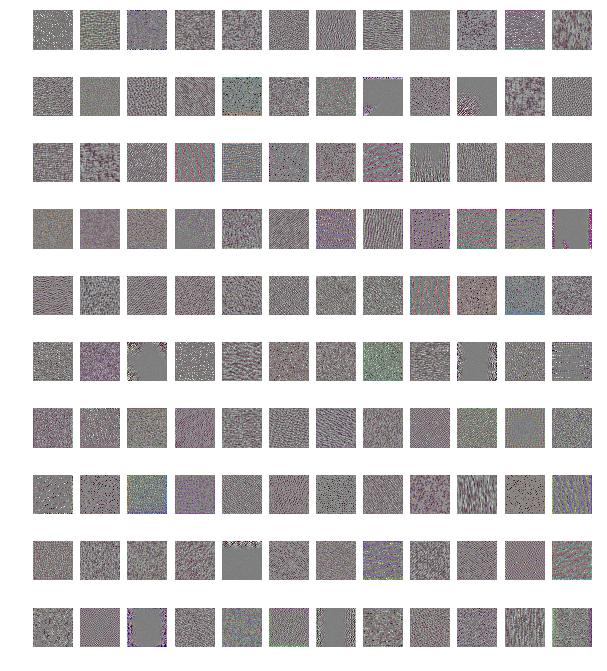

In [0]:
plt.figure(figsize=(10,12))

for i in range(120):
    plt.subplot(10,12,i+1)
    patt1  = get_pattern('block3_conv1',i)
    plt.imshow(patt1)
    plt.axis("off")
plt.show()

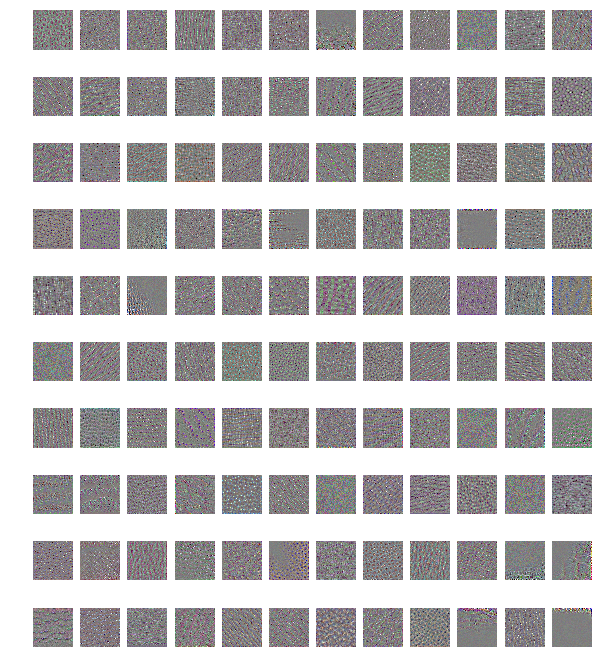

In [0]:
plt.figure(figsize=(10,12))

for i in range(120):
    plt.subplot(10,12,i+1)
    patt1  = get_pattern('block4_conv1',i)
    plt.imshow(patt1)
    plt.axis("off")
plt.show()